In [1]:
import os
import importlib

import cfGPR
import vonkarmanFT as vk
import plotGPR

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy.optimize as opt
from scipy.spatial.ckdtree import cKDTree

In [2]:
GP = cfGPR.CurlFreeGPR()
GP.load_fits("folio2")
GP.extract_data(465)
GP.sigma_clip()
GP.split_data(train_size=0.50)

x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

In [3]:
params = np.array([
    477.861982,
    -0.107816,
    0.064586,
    0.036499,
    0.151514
])

In [4]:
ttt = vk.TurbulentLayer(
    variance=params[0],
    outerScale=params[1],
    diameter=params[2],
    wind=(params[3], params[4]))

/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: divide by zero encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: invalid value encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: divide by zero encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: invalid value encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)


In [5]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [6]:
# Calculate fbar_s normally
du, dv = getGrid(GP.Xtrain, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
n1, n2 = Cuv.shape[0], Cuv.shape[1]
K = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

du, dv = getGrid(GP.Xtest, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
n1, n2 = Cuv.shape[0], Cuv.shape[1]
Ks = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

W = GP.white_noise_kernel(GP.Etrain)

L = np.linalg.cholesky(K + W)

alpha = np.linalg.solve(L.T, np.linalg.solve(L, GP.flat(GP.Ytrain)))

GP.fbar_s = GP.unflat(np.dot(Ks.T, alpha))

/home/fortino/DESworkspace/plotGPR.py:834: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:838: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:842: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:853: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:860: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:861: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:862: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


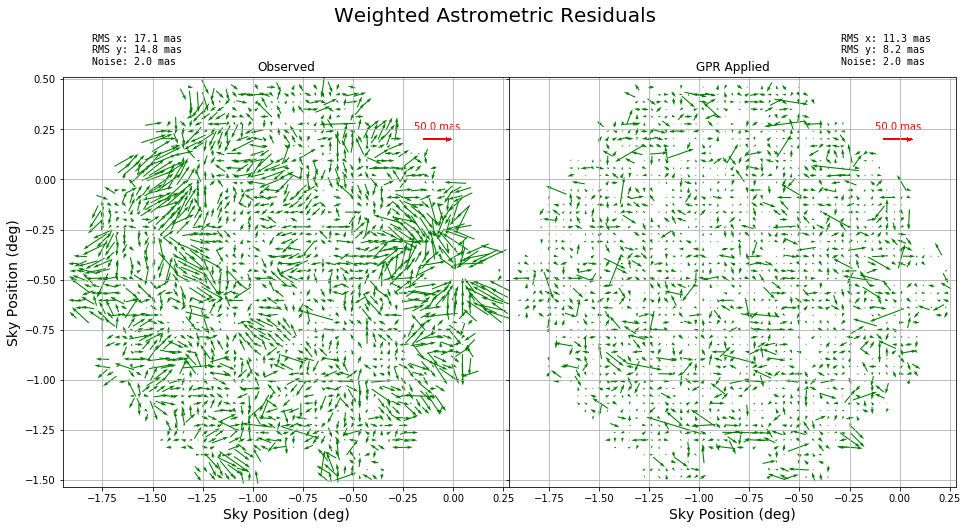

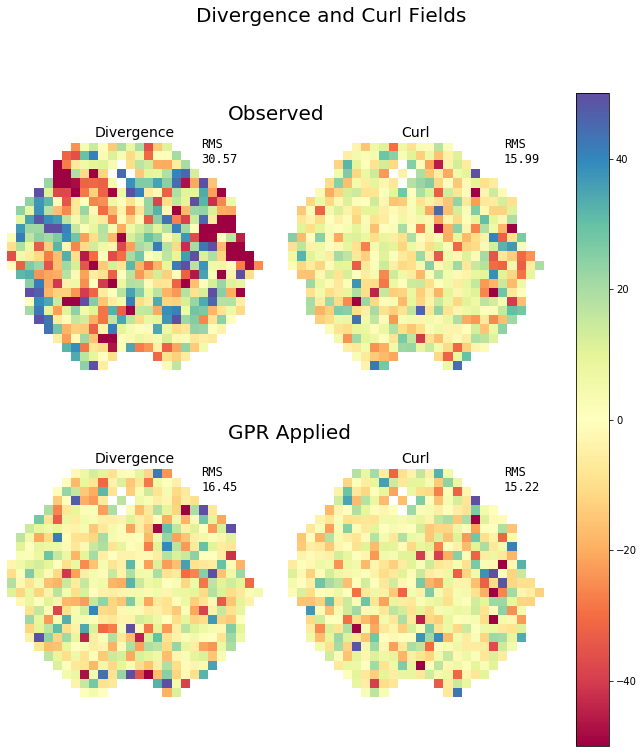

4069 Stars Evaluated...
For the first 39 separation bins...
                    E-Mode    B-Mode    
Mean Observed       429.594   -6.812    
Mean GPR Applied    82.218    10.495    

Std  Observed       131.267   143.783   
Std  GPR Applied    43.002    33.957    

Mean Ratio          5.225     0.649     


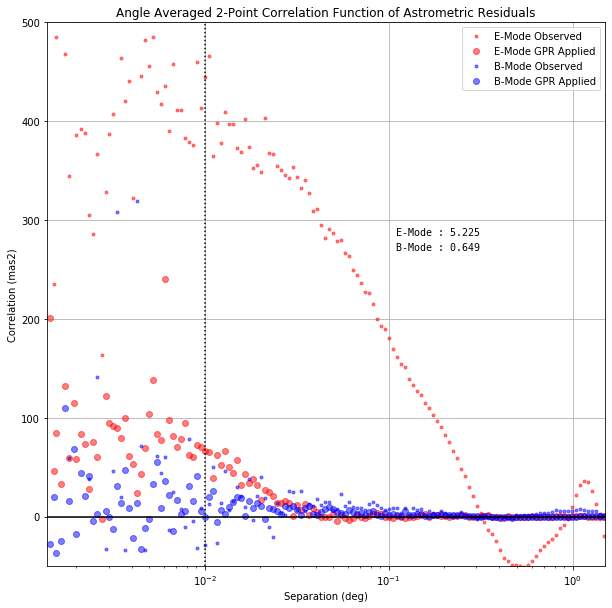

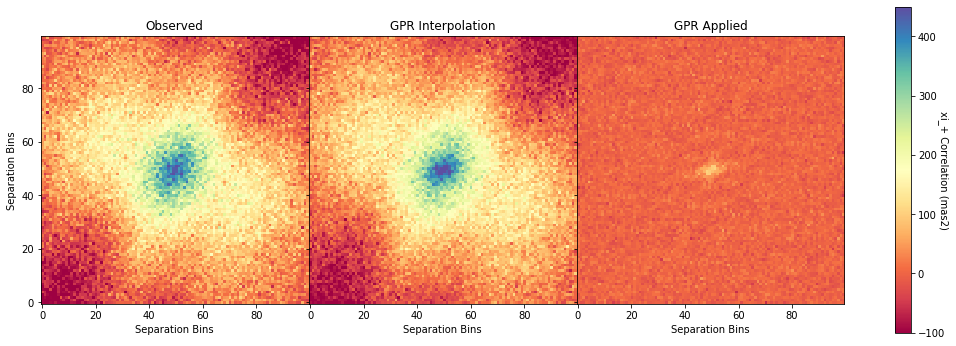

In [7]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas


plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2)

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2)

In [14]:
rmax = 0.3*u.deg
nBins= 1000

dx = (rmax / (nBins / 2)).to(u.deg).value
X = np.arange(-nBins / 2, nBins / 2) * dx
xx, yy = np.meshgrid(X, X)
cuv = ttt.getCuv(xx, yy)

In [15]:
Cuu = cuv[:,:,0,0]
Cvv = cuv[:,:,1,1]
Cuv = cuv[:,:,0,1]
Cvu = cuv[:,:,1,0]

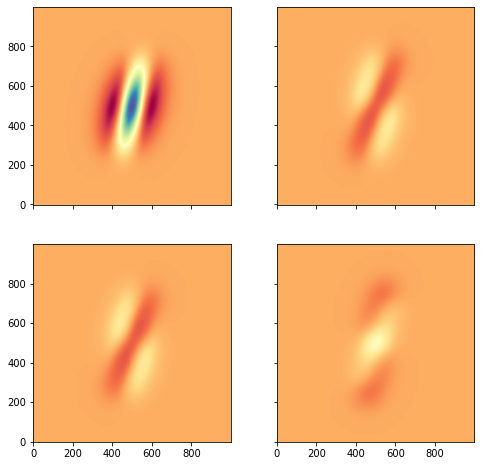

In [16]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    sharex=True, sharey=True,
    figsize=(8, 8))

axes[0,0].imshow(
    Cuu,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[1,1].imshow(
    Cvv,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[0,1].imshow(
    Cuv,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[1,0].imshow(
    Cvu,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())
plt.show()

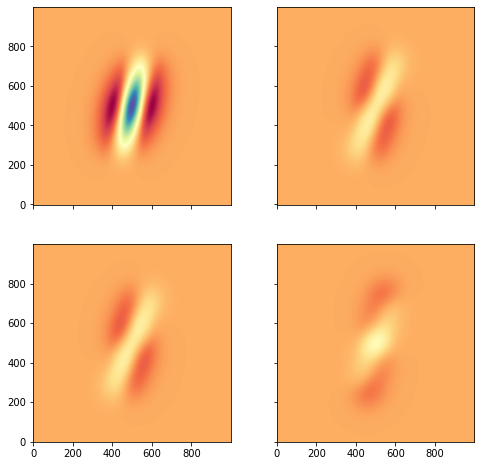

In [10]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    sharex=True, sharey=True,
    figsize=(8, 8))

axes[0,0].imshow(
    Cuu,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[1,1].imshow(
    Cvv,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[0,1].imshow(
    -Cuv,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())

axes[1,0].imshow(
    -Cvu,
    interpolation='nearest',
    origin='lower',
    cmap='Spectral',
    vmin=Cuu.min(),
    vmax=Cuu.max())
plt.show()

In [11]:
# Calculate fbar_s normally
du, dv = getGrid(GP.Xtrain, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
Cuv[:,:,0,1] *= -1
Cuv[:,:,1,0] *= -1
n1, n2 = Cuv.shape[0], Cuv.shape[1]
K = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

du, dv = getGrid(GP.Xtest, GP.Xtrain)
Cuv = ttt.getCuv(du, dv)
Cuv[:,:,0,1] *= -1
Cuv[:,:,1,0] *= -1
n1, n2 = Cuv.shape[0], Cuv.shape[1]
Ks = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

W = GP.white_noise_kernel(GP.Etrain)

L = np.linalg.cholesky(K + W)

alpha = np.linalg.solve(L.T, np.linalg.solve(L, GP.flat(GP.Ytrain)))

GP.fbar_s = GP.unflat(np.dot(Ks.T, alpha))

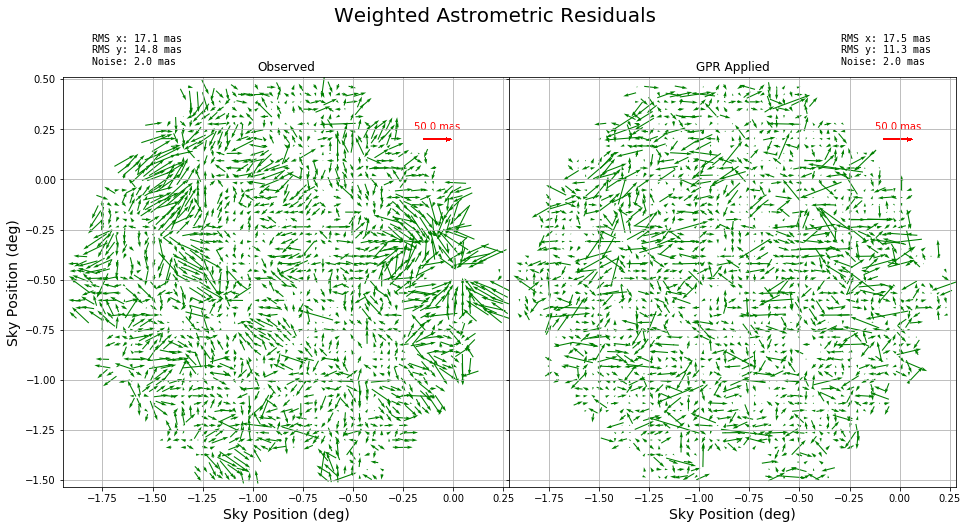

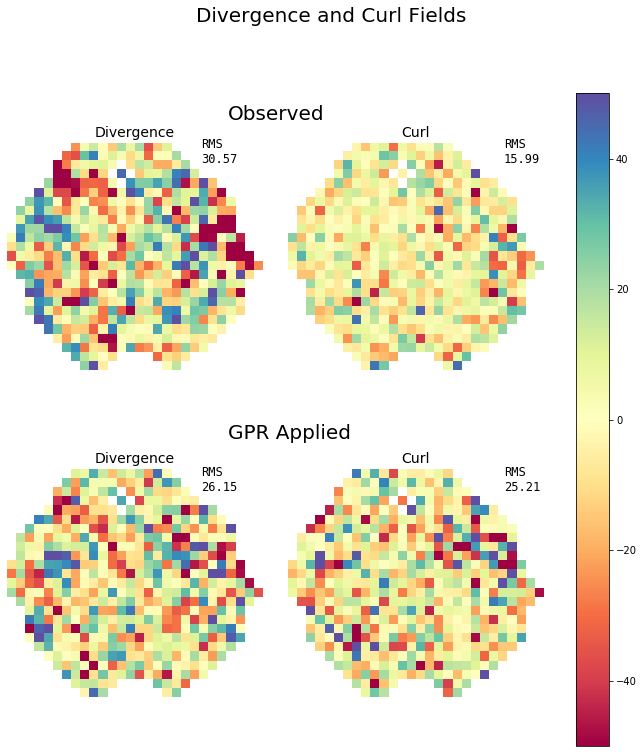

4069 Stars Evaluated...
For the first 39 separation bins...
                    E-Mode    B-Mode    
Mean Observed       429.594   -6.812    
Mean GPR Applied    226.622   96.211    

Std  Observed       131.267   143.783   
Std  GPR Applied    150.542   113.674   

Mean Ratio          1.896     0.071     


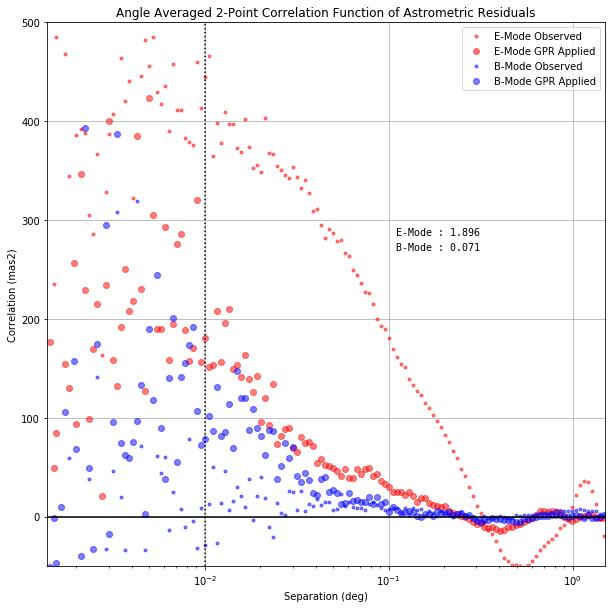

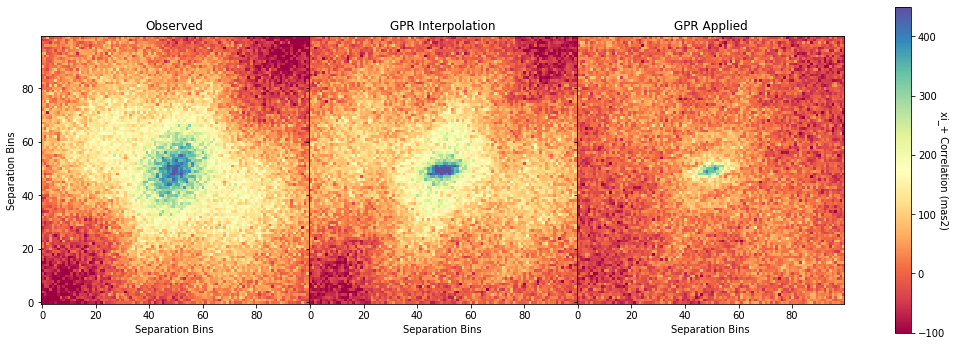

In [12]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas


plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2)

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2)

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2)